In [29]:
# Imports
import pathlib

import torch
import numpy as np
import matplotlib.pyplot as plt

import random

import torch.nn as nn
import torch.optim as optim

from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset

from tqdm.auto import tqdm
from IPython.display import display

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

import pandas as pd
import seaborn as sns



The codes of this notebook are adopted from: https://deeplearning.neuromatch.io/tutorials/W1D3_MultiLayerPerceptrons/student/W1D3_Tutorial2.html

# Utility codes for tran-test split, and Model training Pipeline

In [2]:
def train_test_classification(net, criterion, optimizer, 
                              train_loader,test_loader, num_epochs=1, verbose=True,
                              training_plot=True, device='cpu'):
    
    net.to(device) 
    net.train()
    training_losses = []
    for epoch in tqdm(range(num_epochs)):  # Loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
          # Get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device).float()
            labels = labels.to(device).long()

          # Zero the parameter gradients
            optimizer.zero_grad()

          # forward + backward + optimize
            outputs = net(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

          # Print statistics
            if verbose:
                training_losses += [loss.item()]

    net.eval()

    def test(data_loader):
        correct = 0
        total = 0
        for data in data_loader:
            inputs, labels = data
            inputs = inputs.to(device).float()
            labels = labels.to(device).long()

            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        acc = 100 * correct / total
        return total, acc

    train_total, train_acc = test(train_loader)
    test_total, test_acc = test(test_loader)

    if verbose:
        print(f'\nAccuracy on the {train_total} training samples: {train_acc:0.2f}')
        print(f'Accuracy on the {test_total} testing samples: {test_acc:0.2f}\n')

    if training_plot:
        plt.plot(training_losses)
        plt.xlabel('Batch')
        plt.ylabel('Training loss')
        plt.show()

    return train_acc, test_acc


# @markdown `shuffle_and_split_data(X, y, seed)`
def shuffle_and_split_data(X, y, percent_test, seed):
  # Set seed for reproducibility
    torch.manual_seed(seed)
  # Number of samples
    N = X.shape[0]
  # Shuffle data
    shuffled_indices = torch.randperm(N)   # Get indices to shuffle data, could use torch.randperm
    X = X[shuffled_indices]
    y = y[shuffled_indices]

  # Split data into train/test
    test_size = int(percent_test * N)    # Assign test datset size using 20% of samples
    X_test = X[:test_size]
    y_test = y[:test_size]
    X_train = X[test_size:]
    y_train = y[test_size:]

    return X_test, y_test, X_train, y_train

# Set DEVICE and seed

In [3]:
def set_device():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device != "cuda":
        print("GPU is not enabled in this notebook. \n"
          "You can switch to Colab. If you want to enable GPU, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
    else:
        print("GPU is enabled in this notebook")

    return device


def set_seed(seed=None, seed_torch=True):
    if seed is None:
        seed = np.random.choice(2 ** 32)
        random.seed(seed)
        np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

    print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


# Load MNIST data

In [4]:
## Load MNIST data
digits = datasets.load_digits()
n_samples = len(digits.images)
digit_data = digits.images.reshape((n_samples, -1))
digit_label = digits.target

## Convert numpy arrays to tensors
digit_data = torch.tensor(digit_data)
digit_label = torch.tensor(digit_label)

print("MNIST dataset shape:",digit_data.shape)
print("MNIST dataset label shape:",digit_label.shape)

MNIST dataset shape: torch.Size([1797, 64])
MNIST dataset label shape: torch.Size([1797])


# Make Train-test split

In [5]:
## Set seed for reproducibility 
SEED = 2 
set_seed(seed=SEED)
DEVICE = set_device() # Use CPU or GPU

Random seed 2 has been set.
GPU is not enabled in this notebook. 
You can switch to Colab. If you want to enable GPU, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu


In [6]:
## Train-test split. Use 20% of samples for testing.
X_test, y_test, X_train, y_train = shuffle_and_split_data(digit_data, digit_label, 0.2, seed=SEED)

batch_size = 128
g_seed = torch.Generator()
g_seed.manual_seed(SEED)


## Create dataloaders for Pytorch implementation 
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          drop_last=True,
                          shuffle=True,
                          worker_init_fn=seed_worker,
                          generator=g_seed,
                          )

test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, 
                         batch_size=batch_size,
                         shuffle=False, 
                         worker_init_fn=seed_worker,
                         generator=g_seed,
                         )

all_data = TensorDataset(digit_data, digit_label)
all_data_loader = DataLoader(all_data, 
                         batch_size=batch_size,
                         shuffle=False, 
                         worker_init_fn=seed_worker,
                         generator=g_seed,
                         )



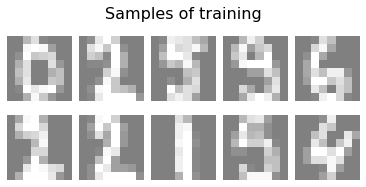

Corresponding labels: tensor([0, 2, 5, 9, 6, 2, 2, 1, 5, 4])


In [7]:
def plot_gallery(title, images, image_shape, n_col, n_row, cmap="gray"):
    ## Input array "Images" is 2-dimensional.
    fig, axs = plt.subplots(
        nrows=n_row,
        ncols=n_col,
        figsize=(1.0 * n_col, 1.3 * n_row),
        facecolor="white",
        constrained_layout=True,
    )
    fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.1, hspace=0, wspace=0)
    fig.set_edgecolor("black")
    fig.suptitle(title, size=16)
    for ax, img_vect in zip(axs.flat, images):
        vmax = max(img_vect.max(), -img_vect.min())
        im = ax.imshow(
            img_vect.reshape(image_shape),
            cmap=cmap,
            #interpolation="nearest",
            vmin=-vmax,
            vmax=vmax,
        )
        ax.axis("off")

    plt.show()
    
plot_gallery("Samples of training", X_train[:10], (8,8),5, 2)
print("Corresponding labels:",y_train[:10])

# MLP model

In [8]:
class Net(nn.Module):
    def __init__(self, actv, input_feature_num, hidden_unit_nums, output_feature_num):
        
        
        super(Net, self).__init__()
        self.input_feature_num = input_feature_num # Save the input size for reshapinng later
        self.MLP = nn.Sequential() # Initialize layers of MLP

        in_num = input_feature_num # Initialize the temporary input feature to each layer
        for i in range(len(hidden_unit_nums)):
            # Loop over layers and create each one
            out_num = hidden_unit_nums[i] # Assign the current layer hidden unit from list
            layer = nn.Linear(in_num, out_num) # Use nn.Linear to define the layer
            in_num = out_num # Assign next layer input using current layer output
            self.MLP.add_module(f"Linear_{i}", layer) # Append layer to the model with a name

            actv_layer = eval(f"nn.{actv}") # Assign activation function (eval allows us to instantiate object from string)
            self.MLP.add_module(f"Activation_{i}", actv_layer) # Append activation to the model with a name

        out_layer = nn.Linear(in_num, output_feature_num) # Create final layer
        self.MLP.add_module('Output_Linear', out_layer) # Append the final layer

    def forward(self, x):
        
        # Reshape inputs to (batch_size, input_feature_num)
        # Just in case the input vector is not 2D, like an image!
        x = x.view(-1, self.input_feature_num)

        logits = self.MLP(x) # forward pass of MLP
        return logits

In [9]:
activation = "ReLU()"
input_feature_num = 64 #input feature size, which is a grayscale image with width = height = 8
hidden_unit_nums = [128, 100, 50] # Set the number of unit in each hidden layer
output_feature_num = 10

## Initialize a MLP model
mlp_1 = Net(actv = activation,
            input_feature_num = input_feature_num,
            hidden_unit_nums = hidden_unit_nums,
            output_feature_num = output_feature_num)

mlp_1

Net(
  (MLP): Sequential(
    (Linear_0): Linear(in_features=64, out_features=128, bias=True)
    (Activation_0): ReLU()
    (Linear_1): Linear(in_features=128, out_features=100, bias=True)
    (Activation_1): ReLU()
    (Linear_2): Linear(in_features=100, out_features=50, bias=True)
    (Activation_2): ReLU()
    (Output_Linear): Linear(in_features=50, out_features=10, bias=True)
  )
)

Check the number of parameters

In [38]:
def count_param(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name, param.data.shape)
            
count_param(mlp_1)
        

MLP.Linear_0.weight torch.Size([128, 64])
MLP.Linear_0.bias torch.Size([128])
MLP.Linear_1.weight torch.Size([100, 128])
MLP.Linear_1.bias torch.Size([100])
MLP.Linear_2.weight torch.Size([50, 100])
MLP.Linear_2.bias torch.Size([50])
MLP.Output_Linear.weight torch.Size([10, 50])
MLP.Output_Linear.bias torch.Size([10])


  0%|          | 0/30 [00:00<?, ?it/s]


Accuracy on the 1408 training samples: 98.44
Accuracy on the 359 testing samples: 99.16



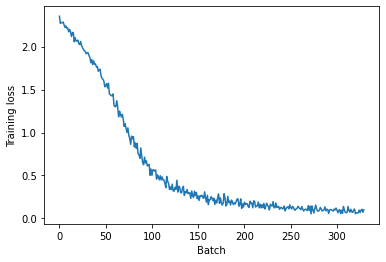

In [10]:
## Start training
criterion = nn.CrossEntropyLoss() # define loss for multiclass classification
optimizer = optim.Adam(mlp_1.parameters(), lr=2e-4)
train_accu, test_accu = train_test_classification(mlp_1, criterion, optimizer,
                                train_loader, test_loader,
                                num_epochs=30, device=DEVICE)

# Extract features from MLP 

In [16]:
## Get the layer weights
# fc1_weights = net.mlp[0].weight.view(64, 3, 32, 32).detach().cpu()
# fc1_weights /= torch.max(torch.abs(fc1_weights))

## Extract an layer's activation
def get_feature(net, net_layer, data, hooked_layer):
    """net: the Model
       net_layer: a specific layer of model in __init__
       data: the input data
       hooked_layer: layer name, a str"""
    device = DEVICE
    
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    
    net_layer.register_forward_hook(get_activation(hooked_layer))
    
    x = data.to(device).float()
    output = net(x)
    
    return activation[hooked_layer]

Using a forward hook to store one activation from a specific layer.

In [32]:
## Get the activation for certain input data

MLP_Linear_2 = get_feature(mlp_1, mlp_1.MLP.Linear_2, digit_data, 'Linear_2')
MLP_ReLu2 = get_feature(mlp_1, mlp_1.MLP.Activation_2, digit_data, 'Activation_2') 

print(MLP_Linear_2.shape)
print(MLP_ReLu2.shape)



torch.Size([1797, 50])
torch.Size([1797, 50])


We can now use the trained MLP model as a feature extractor.

In [34]:
## Visualize features with tSNE
perplexity = 40
tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=300, init='pca', random_state = 1)

train_std =  StandardScaler().fit_transform(MLP_ReLu2) 
print(train_std.shape)
tsne_results = tsne.fit_transform(train_std)

tsne_df = pd.DataFrame({"feature_1":tsne_results[:,0], "feature_2":tsne_results[:,1], "class_label":digit_label})

def plot_tSNE(X_fitted):
    """Plot tSNE results"""
    
    hue_order = list(range(10))
    
    plt.figure(figsize =(10, 10))
    
    sns.set_context("notebook")
    sns.set_style("ticks")
    sns.scatterplot(data=X_fitted, 
                    x="feature_1", 
                    y="feature_2", 
                    hue="class_label",
                    palette="deep",
                    hue_order = hue_order,
                    legend=True,
                    s = 50,
                    alpha = 0.5)
    sns.despine()
    
    plt.gca().set(
        aspect="equal",
        title="2-dimensional dataset with tSNE",
        xlabel="first tSNE feature",
        ylabel="second tSNE feature",
    )
    
    plt.legend(loc='center left', title="label", bbox_to_anchor=(1, 0.5))
    plt.show()
     
plot_tSNE(tsne_df)

(1797, 50)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1797 samples in 0.001s...
[t-SNE] Computed neighbors for 1797 samples in 0.074s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1797
[t-SNE] Computed conditional probabilities for sample 1797 / 1797
[t-SNE] Mean sigma: 1.628999


/Users/chenxiliao/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/chenxiliao/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.417789
[t-SNE] KL divergence after 300 iterations: 0.875947


# Compare the MLP model with different initialization

In [ ]:
N = 10  # Number of trials
gains = np.linspace(1/N, 3.0, N)
test_accs = []
train_accs = []
mode = 'uniform'
for gain in gains:
    
    print(f'\ngain: {gain}')

    def init_weights(m, mode='normal'):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_normal_(m.weight, gain)

    negative_slope = 0.1
    activation = f'LeakyReLU({negative_slope})'
    set_seed(seed=SEED)
    net = Net(actv = activation,
            input_feature_num = input_feature_num,
            hidden_unit_nums = hidden_unit_nums,
            output_feature_num = output_feature_num)
    net.apply(init_weights)
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.SGD(net.parameters(), lr=1e-2)
    train_acc, test_acc = train_test_classification(net, criterion, optimizer,
                                                  train_loader,
                                                  test_loader,
                                                  num_epochs=50,
                                                  verbose=True,
                                                  device=DEVICE)
    test_accs += [test_acc]
    train_accs += [train_acc]

best_gain = gains[np.argmax(train_accs)]
plt.plot(gains, test_accs, label='Test accuracy')
plt.plot(gains, train_accs, label='Train accuracy')
plt.scatter(best_gain, max(train_accs),
            label=f'best gain={best_gain:.1f}',
            c='k', marker ='x')

# Calculate and plot the theoretical gain
theoretical_gain = np.sqrt(2.0 / (1 + negative_slope ** 2))
plt.scatter(theoretical_gain, max(train_accs),
            label=f'theoretical gain={theoretical_gain:.2f}',
            c='g', marker ='x')
plt.legend()
plt.plot()

In [49]:
from random import random
random()

0.24740037808939686